In [1]:
cd ../../../cd_hit_py/

/Users/in-divye.singh/Documents/Projects/cd_hit_py


In [2]:
from cd_hit import CD_HIT

In [3]:
cd ../MIC_predictor/src/

/Users/in-divye.singh/Documents/Projects/MIC_predictor/src


In [4]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain, combinations
from collections import Counter

from utils import *

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [5]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [6]:
def pearson_score(y_true, y_pred):
    pcc = pearsonr(y_true, y_pred)
    return pcc[0]

pcc_scorer = make_scorer(pearson_score)

In [7]:
avp_ic50 = pd.read_csv("../data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("../data/raw/HA_AVP.csv")

In [8]:
df = pd.concat([avp_ic50[['Sequence','MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)

In [9]:
df['pIC50'] = df['MIC'].apply(lambda x: -np.log(x*1e-6))

In [10]:
family = pd.read_csv("../data/raw/712pep_family.csv")

In [12]:
family['Family'].unique()

array(['Arenaviridae', 'Arteriviridae', 'Asfarviridae', 'Bunyaviridae',
       'Coronaviridae', 'Family', 'Filoviridae', 'Flaviviridae',
       'Hepadnaviridae', 'Herpesviridae', 'Orthomyxoviridae',
       'Papillomaviridae', 'Paramyxoviridae', 'Polyomaviridae',
       'Poxviridae', 'Retroviridae'], dtype=object)

In [23]:
flaviviridae_seq = family[(family['Family'] == "Flaviviridae")].reset_index(drop=True)

In [24]:
flaviviridae_seq

,Sequence,Abbreviation,Family
0,AAQRRGRVGRNPNQVGD,HCV,Flaviviridae
1,RNPSQVGD,WNV,Flaviviridae
2,RVGRNPNQVGD,HCV,Flaviviridae
3,AAQRRGRIGRNPSQVGD,HCV,Flaviviridae
4,RGRRGIYR,HCV,Flaviviridae
...,...,...,...
125,TWLRAIWDWVCTALTDFK,HCV,Flaviviridae
126,SWLRDVWDWVCTVLSDFK,HCV,Flaviviridae
127,GAIVSTALPQWRIYSYAG,HCV,Flaviviridae
128,SWLRDIWDWLCELLSDFK,HCV,Flaviviridae


In [30]:
df_flaviviridae = df.merge(flaviviridae_seq,how='right',on='Sequence').reset_index(drop=True)

In [33]:
df_flaviviridae#.to_csv("../data/raw/flaviviridae_data.csv", index=False)

,Sequence,MIC,pIC50,Abbreviation,Family
0,AAQRRGRVGRNPNQVGD,442.00,7.724201,HCV,Flaviviridae
1,RNPSQVGD,383.00,7.867476,WNV,Flaviviridae
2,RVGRNPNQVGD,374.00,7.891255,HCV,Flaviviridae
3,AAQRRGRIGRNPSQVGD,358.00,7.934978,HCV,Flaviviridae
4,RGRRGIYR,313.00,8.069307,HCV,Flaviviridae
...,...,...,...,...,...
125,TWLRAIWDWVCTALTDFK,7.10,11.855416,HCV,Flaviviridae
126,SWLRDVWDWVCTVLSDFK,3.50,12.562748,HCV,Flaviviridae
127,GAIVSTALPQWRIYSYAG,23.80,10.645825,HCV,Flaviviridae
128,SWLRDIWDWLCELLSDFK,0.82,14.013961,HCV,Flaviviridae


In [34]:
def get_physicochemical_properties(df):
    params = ['aromaticity', 'helix', 'turn', 'sheet', 'gravy', 'net_charge_at_pH7point4']

    prop = []
    for seq in df.Sequence:
        X = ProteinAnalysis(seq)
        aromaticity = X.aromaticity()
        sec_struc = X.secondary_structure_fraction()
        helix = sec_struc[0]
        turn = sec_struc[1]
        sheet = sec_struc[2]
        gravy = X.gravy() # hydrophobicity related
        net_charge_at_pH7point4 = X.charge_at_pH(7.4)

        prop.append([aromaticity, helix, turn, sheet, gravy, net_charge_at_pH7point4])
    return pd.DataFrame(prop, columns=params)

In [35]:
aa_freq = reduce_by_kmer_frequency(df_flaviviridae)

In [36]:
uniprot_embedding = biovec.models.load_protvec("../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_protvec = convert_sequences_to_avg_vectors(df_flaviviridae['Sequence'], uniprot_embedding, kmer=3)
avg_protvec = avg_protvec.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 130/130 [00:00<00:00, 1082.24sequence/s]


In [37]:
physicochemical_prop = get_physicochemical_properties(df_flaviviridae)

In [38]:
X = pd.concat([aa_freq, avg_protvec, physicochemical_prop[['helix','turn','sheet']]], axis=1)

In [39]:
y = df_flaviviridae[['pIC50', 'MIC']]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
y_train_pmic, y_train_mic = y_train['pIC50'], y_train['MIC']
y_test_pmic, y_test_mic = y_test['pIC50'], y_test['MIC']

In [42]:
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut

In [46]:
from scipy.stats import pearsonr

In [47]:
def multi_objective_score(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    pcc = pearson_score(y_true, y_pred)
    return mape - 10*pcc
multi_objective_scorer = make_scorer(multi_objective_score, greater_is_better=False)

In [50]:
max_n_neighbors = int(np.sqrt(X_train.shape[0]))
param_grid = {
    'n_neighbors': range(1, max_n_neighbors),
    'weights': ['uniform', 'distance'],
    'metric': ["euclidean", "manhattan", "chebyshev"]
}
knn = KNeighborsRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = knn, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring=mape_scorer)

In [51]:
grid_search.fit(X_train, y_train_pmic)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    0.5s finished


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'n_neighbors': range(1, 10),
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
             verbose=2)

In [52]:
grid_search.best_params_

{'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}

In [53]:
best_grid = grid_search.best_estimator_

In [54]:
y_pred_pmic = best_grid.predict(X_test)

In [55]:
mean_absolute_percentage_error(y_test_pmic, y_pred_pmic)

12.39909277786959

In [56]:
y_pred_mic = np.exp(-y_pred_pmic)/1e-6

In [57]:
ape_mic = 100*np.abs(y_test_mic-y_pred_mic)/y_test_mic

In [58]:
mean_absolute_percentage_error(y_test_mic, y_pred_mic)

295.4050369014247

In [59]:
pearson_score(y_test_mic, y_pred_mic)

0.027843813550565283

In [60]:
list(zip(y_test_mic.round(4), y_pred_mic.round(4), ape_mic))

[(8.9, 4.3, 51.68539325842702),
 (12.5, 21.5, 72.0),
 (27.0, 27.0, 5.26327952414889e-14),
 (21.4, 11.7, 45.327102803738335),
 (0.024, 0.001, 95.83333333333333),
 (8.0, 25.0, 212.50000000000023),
 (5.0, 5.0, 1.7763568394002505e-14),
 (0.51, 1.7, 233.33333333333348),
 (3.0, 10.0, 233.33333333333326),
 (25.0, 25.0, 7.105427357601002e-14),
 (1.115, 0.811, 27.264573991031575),
 (25.0, 25.0, 7.105427357601002e-14),
 (5.1, 4.0, 21.568627450980195),
 (313.0, 0.2, 99.93610223642173),
 (0.89, 0.84, 5.617977528089906),
 (0.8, 10.0, 1149.9999999999995),
 (13.5, 13.0, 3.7037037037036904),
 (3.0, 4.0, 33.33333333333342),
 (1.2, 0.79, 34.166666666666714),
 (1.965, 36.0, 1732.0610687022888),
 (27.0, 27.0, 5.26327952414889e-14),
 (36.0, 358.0, 894.4444444444441),
 (0.001, 0.026, 2499.9999999999964),
 (34.6, 0.2, 99.42196531791907),
 (3.5, 2.1, 39.99999999999996),
 (10.0, 0.5, 94.99999999999997)]

In [61]:
loo = LeaveOneOut()

from tqdm import tqdm

result_df = pd.DataFrame(columns = list(df_flaviviridae.columns)+["y_pred_pmic", "y_pred_mic", "ape_pmic", "ape_mic"])
for train_index, test_index in tqdm(loo.split(X)):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    y_train_pmic, y_train_mic = y_train['pIC50'], y_train['MIC']
    y_test_pmic, y_test_mic = y_test['pIC50'], y_test['MIC']
    knn = KNeighborsRegressor(**grid_search.best_params_)
    _ = knn.fit(X_train, y_train_pmic)
    y_pred_pmic = knn.predict(X_test)
    y_pred_mic = np.exp(-y_pred_pmic)/1e-6
    ape = 100*np.abs(y_test_pmic-y_pred_pmic)/y_test_pmic
    ape_mic = 100*np.abs(y_test_mic-y_pred_mic)/y_test_mic
    df_val = df_flaviviridae.iloc[test_index,:].values[0].tolist()
    res = np.append(df_val, [y_pred_pmic[0], y_pred_mic[0], ape.values[0], ape_mic.values[0]])
    res = pd.DataFrame([res], columns = list(df_flaviviridae.columns)+["y_pred_pmic", "y_pred_mic", "ape_pmic", "ape_mic"])
    result_df = result_df.append(res)
result_df = result_df[["Sequence", "pIC50", "y_pred_pmic", "ape_pmic", "MIC", "y_pred_mic", "ape_mic"]]

130it [00:01, 110.28it/s]


In [62]:
result_df#.to_csv("../results/SVM_HIV_CoV_pMIC_to_MIC_rbf_c_100_gamma_2.csv", index=False)

,Sequence,pIC50,y_pred_pmic,ape_pmic,MIC,y_pred_mic,ape_mic
0,AAQRRGRVGRNPNQVGD,7.724200675886576,7.934977571563574,2.7287858578687905,442.0,357.9999999999999,19.004524886877853
0,RNPSQVGD,7.867475568783628,8.163021377695623,3.75655197563821,383.0,285.0000000000002,25.587467362924226
0,RVGRNPNQVGD,7.891254760549742,8.537395898733758,8.188065875331112,374.0,195.99999999999983,47.593582887700585
0,AAQRRGRIGRNPSQVGD,7.934977571563574,7.724200675886576,2.65630108939886,358.0,442.00000000000006,23.463687150838005
0,RGRRGIYR,8.069307367424122,10.271656875900595,27.292918811933987,313.0,34.60000000000002,88.94568690095845
...,...,...,...,...,...,...,...
0,TWLRAIWDWVCTALTDFK,11.855415773917004,13.073573213234896,10.275113606710862,7.1,2.1000000000000014,70.42253521126759
0,SWLRDVWDWVCTVLSDFK,12.562747589468906,13.073573213234896,4.06619348297824,3.5,2.1000000000000014,39.99999999999996
0,GAIVSTALPQWRIYSYAG,10.645824977286845,10.596634733096073,0.46206136486106625,23.8,25.000000000000018,5.042016806722761
0,SWLRDIWDWLCELLSDFK,14.013961496688113,13.633189001170319,2.71709391814571,0.82,1.2000000000000008,46.34146341463426


In [63]:
result_df['ape_pmic'].astype('float').mean()

9.306446939211979

In [64]:
result_df['ape_mic'].astype('float').mean()

465.7247660234492

In [65]:
pearsonr(result_df['MIC'].astype('float'), result_df['y_pred_mic'].astype('float'))

(0.6860035156421072, 2.1360323463233672e-19)

### Train with MIC

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
y_train_pmic, y_train_mic = y_train['pIC50'], y_train['MIC']
y_test_pmic, y_test_mic = y_test['pIC50'], y_test['MIC']

In [80]:
max_n_neighbors = int(np.sqrt(X_train.shape[0]))
param_grid = {
    'n_neighbors': range(1, max_n_neighbors),
    'weights': ['uniform', 'distance'],
    'metric': ["euclidean", "manhattan", "chebyshev"]
}
knn = KNeighborsRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = knn, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring=mape_scorer)

In [81]:
grid_search.fit(X_train, y_train_mic)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    0.5s finished


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'n_neighbors': range(1, 10),
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
             verbose=2)

In [82]:
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'uniform'}

In [83]:
best_grid = grid_search.best_estimator_

In [91]:
y_pred_mic = best_grid.predict(X_test)

In [92]:
mean_absolute_percentage_error(y_test_mic, y_pred_mic)

222.71862529455512

In [93]:
len(y_test_mic), len(y_pred_mic)

(26, 26)

In [94]:
pearson_score(y_test_mic, y_pred_mic)

0.06434380515146433

In [95]:
from sklearn.metrics import r2_score

In [96]:
r2_score(y_test_mic, y_pred_mic)

-1.4720044717800724

In [97]:
ape_mic = 100*np.abs(y_test_mic-y_pred_mic)/y_test_mic

In [98]:
list(zip(y_test_mic.round(4), y_pred_mic.round(4), ape_mic))

[(8.9, 4.15, 53.37078651685393),
 (12.5, 22.65, 81.19999999999999),
 (27.0, 13.895, 48.53703703703704),
 (21.4, 5.8555, 72.63785046728971),
 (0.024, 0.012, 50.0),
 (8.0, 7.0, 12.5),
 (5.0, 3.1, 38.0),
 (0.51, 1.245, 144.11764705882356),
 (3.0, 5.335, 77.83333333333333),
 (25.0, 5.8, 76.8),
 (1.115, 4.2055, 277.17488789237666),
 (25.0, 14.5, 42.0),
 (5.1, 4.15, 18.627450980392144),
 (313.0, 12.25, 96.08626198083067),
 (0.89, 1.27, 42.69662921348314),
 (0.8, 10.0, 1149.9999999999998),
 (13.5, 12.75, 5.555555555555555),
 (3.0, 7.0, 133.33333333333334),
 (1.2, 1.245, 3.750000000000013),
 (1.965, 20.5, 943.2569974554707),
 (27.0, 27.0, 0.0),
 (36.0, 400.0, 1011.1111111111111),
 (0.001, 0.0135, 1250.0),
 (34.6, 12.25, 64.59537572254335),
 (3.5, 1.75, 50.0),
 (10.0, 5.25, 47.5)]

In [99]:
loo = LeaveOneOut()

from tqdm import tqdm

result_df = pd.DataFrame(columns = list(df_flaviviridae.columns)+["y_pred_pmic", "y_pred_mic", "ape_pmic", "ape_mic"])
for train_index, test_index in tqdm(loo.split(X)):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    y_train_pmic, y_train_mic = y_train['pIC50'], y_train['MIC']
    y_test_pmic, y_test_mic = y_test['pIC50'], y_test['MIC']
    knn = KNeighborsRegressor(**grid_search.best_params_)
    _ = knn.fit(X_train, y_train_pmic)
    y_pred_pmic = knn.predict(X_test)
    y_pred_mic = np.exp(-y_pred_pmic)/1e-6
    ape = 100*np.abs(y_test_pmic-y_pred_pmic)/y_test_pmic
    ape_mic = 100*np.abs(y_test_mic-y_pred_mic)/y_test_mic
    df_val = df_flaviviridae.iloc[test_index,:].values[0].tolist()
    res = np.append(df_val, [y_pred_pmic[0], y_pred_mic[0], ape.values[0], ape_mic.values[0]])
    res = pd.DataFrame([res], columns = list(df_flaviviridae.columns)+["y_pred_pmic", "y_pred_mic", "ape_pmic", "ape_mic"])
    result_df = result_df.append(res)
result_df = result_df[["Sequence", "pIC50", "y_pred_pmic", "ape_pmic", "MIC", "y_pred_mic", "ape_mic"]]

130it [00:01, 107.77it/s]


In [111]:
result_df#.to_csv("../results/kNN_flaviviridae_dist_manhattan_k_2_weight_uniform.csv", index=False)

,Sequence,pIC50,y_pred_pmic,ape_pmic,MIC,y_pred_mic,ape_mic
0,AAQRRGRVGRNPNQVGD,7.724200675886576,8.236186735148666,6.628337102380169,442.0,264.892430997943,40.06958574707172
0,RNPSQVGD,7.867475568783628,8.027138069122682,2.0293993790404454,383.0,326.4812398898293,14.75685642563204
0,RVGRNPNQVGD,7.891254760549742,8.35020863821469,5.815981001644599,374.0,236.34720222587785,36.8055609021717
0,AAQRRGRIGRNPSQVGD,7.934977571563574,8.244927613300657,3.9061237280347814,358.0,262.5871283974139,26.65164011245422
0,RGRRGIYR,8.069307367424122,12.848302673149485,59.224355798097584,313.0,2.630589287593182,99.15955613814914
...,...,...,...,...,...,...,...
0,TWLRAIWDWVCTALTDFK,11.855415773917004,12.8181604013519,8.120715846617728,7.1,2.7110883423451964,61.81565715006766
0,SWLRDVWDWVCTVLSDFK,12.562747589468906,13.276305767288978,5.67995315306847,3.5,1.7146428199482266,51.01020514433638
0,GAIVSTALPQWRIYSYAG,10.645824977286845,10.672046177963365,0.24630501377266656,23.8,23.18404623873927,2.588041013700547
0,SWLRDIWDWLCELLSDFK,14.013961496688113,13.633189001170319,2.71709391814571,0.82,1.2000000000000008,46.34146341463426


In [101]:
result_df['ape_pmic'].astype('float').mean()

9.116821067174463

In [102]:
result_df['ape_mic'].astype('float').mean()

280.6402501970607

In [103]:
pearsonr(result_df['MIC'].astype('float'), result_df['y_pred_mic'].astype('float'))

(0.7664699128192671, 2.235721695230114e-26)

In [114]:
r2_score(result_df['MIC'].astype('float'), result_df['y_pred_mic'].astype('float'))

0.5723300691225495

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

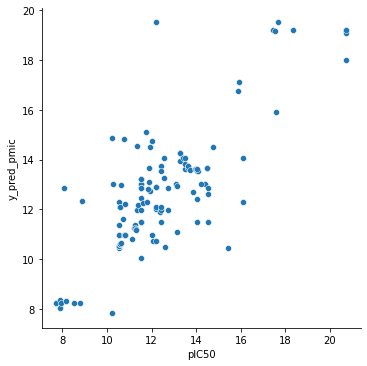

In [108]:
sns.relplot(x=result_df['pIC50'].astype('float'), y=result_df['y_pred_pmic'].astype('float'))

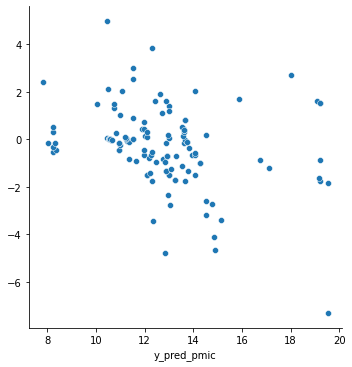

In [109]:
sns.relplot(x=result_df['y_pred_pmic'].astype('float'), y=result_df['pIC50'].astype('float')-result_df['y_pred_pmic'].astype('float'))